# POC 5

## Inference

Let's walk through deploying a DCN model in Sagemaker!

In [47]:
#!pip install easydict

In [148]:
%pylab inline
import os
import boto3
import time
import io
from matplotlib.pyplot import imshow, imread
import subprocess
from skimage.transform import resize as skresize
from PIL import Image
import requests
import cv2
import random
import numpy as np
import json
import sagemaker
from sagemaker.predictor import StringDeserializer
from sagemaker.predictor import RealTimePredictor, json_deserializer
import image_pb2 as impb
import ast
from IPython.display import clear_output
from dcn.lib.utils.show_boxes import show_boxes


sess = sagemaker.Session() # can use LocalSession() to run container locally
bucket = 'privisaa-bucket-virginia' #sess.default_bucket() # can replace with our own bucket 
role = sagemaker.session.get_execution_role()
s3 = boto3.client('s3')

#!cp /home/ec2-user/SageMaker/SageMaker-Inference-Advanced/n-labs/11-manual-model-load/dcn/model/rfcn_dcn_coco-0000.params dcn/model/

Populating the interactive namespace from numpy and matplotlib


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'f', 'resize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Lets take a look at our inference script

In [23]:
!pygmentize inference.py

#LOCAL inference.py - EDIT THIS

"""======CUSTOM============"""
import sys
sys.path.append('/home/model-server')

"""======CUSTOM============"""
import mxnet as mx
import os
import json
import numpy as np
from collections import namedtuple
import logging
import cv2
import PIL
from PIL import Image
import io

"""======CUSTOM============"""

print('~custom start')

from json import JSONEncoder
from dcn.rfcn.config.config import config, update_config
from dcn.lib.utils.image import resize, transform
from dcn.rfcn import _init_paths
import numpy as np
import argparse
import logging
import pprint
import sys
import cv2
import os
import mxnet as mx
from dcn.rfcn.core.tester import im_detect, Predictor
from dcn.rfcn.symbols import *
from dcn.lib.utils.load_model import load_param
#from dcn.lib.utils.show_boxes import show_boxes
from dcn.lib.utils.tictoc import tic, toc
from dcn.lib.nms.nms import py_nms_wrapper, cpu_nms_wrapper, gpu_nms_wrapper

# get config
os.environ['PYTHONUNBUFFERED'] = '1

In order to deploy our model to an endpoint, we need to put our weights into gzip format

In [6]:
!(cd dcn/model/ && tar -czvf /tmp/model-rfcn.tar.gz *)

rfcn_dcn_coco-0000.params


In [41]:
s3.upload_file('/tmp/model-rfcn.tar.gz', bucket, 'super_models/model-rfcn.tar.gz')
!aws s3 ls s3://privisaa-bucket-virginia/super_models/   

2020-06-11 01:53:22  235488910 model-rfcn.tar.gz


Now we create our container we will use for DCN inference.

In [1]:
%%sh

# The name of our algorithm
algorithm_name=mxnet-serving-160-gpu-py2

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
#region=${region:-us-west-2}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

#docker build -t chazarey-mxnet-serving:1.6.0-gpu-py3 -f docker/1.6.0/py3/Dockerfile.gpu .

docker build -t ${algorithm_name} -f Dockerfile.gpu .

docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

Login Succeeded
Sending build context to Docker daemon  289.1MB
Step 1/32 : FROM nvidia/cuda:10.0-cudnn7-runtime-ubuntu16.04
 ---> 0489a321f88b
Step 2/32 : LABEL maintainer="Amazon AI"
 ---> Using cache
 ---> 07998723caa8
Step 3/32 : LABEL com.amazonaws.sagemaker.capabilities.accept-bind-to-port=true
 ---> Using cache
 ---> e5ae5a9b40bb
Step 4/32 : ARG MMS_VERSION=1.0.8
 ---> Using cache
 ---> 7524f404ae75
Step 5/32 : ARG MX_URL=https://aws-mxnet-pypi.s3-us-west-2.amazonaws.com/1.6.0/aws_mxnet_cu101mkl-1.6.0-py2.py3-none-manylinux1_x86_64.whl
 ---> Using cache
 ---> 77079440a462
Step 6/32 : ARG PYTHON=python
 ---> Using cache
 ---> 8efbeecd8eb0
Step 7/32 : ARG PYTHON_PIP=python-pip
 ---> Using cache
 ---> cf73208dbb0b
Step 8/32 : ARG PIP=pip
 ---> Using cache
 ---> 91e971d80d47
Step 9/32 : ENV PYTHONDONTWRITEBYTECODE=1     PYTHONUNBUFFERED=1     LD_LIBRARY_PATH="${LD_LIBRARY_PATH}:/usr/local/lib:/usr/local/cuda-10.0/targets/x86_64-linux/lib"     PYTHONIOENCODING=UTF-8     LANG=C.UTF-8 

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



Now that we have built our container, we can deploy our endpoint. This process usually takes some time.

In [2]:
%%time

from sagemaker.mxnet import MXNetModel

model_data="s3://privisaa-bucket-virginia/super_models/model-rfcn.tar.gz"

model = MXNetModel(
    model_data=model_data,
    role=role,
    image="209419068016.dkr.ecr.us-east-1.amazonaws.com/chazarey-mxnet-serving-160-gpu-py2",
    entry_point="inference.py",
    py_version='py2',
    framework_version='1.6.0',
    enable_cloudwatch_metrics=True
)

# for deploying the endpoint locally for testing we can use an instance_type of local
#predictor = model.deploy(instance_type="local_gpu", initial_instance_count=1)
#predictor = model.deploy(instance_type="local", initial_instance_count=1)

predictor = model.deploy(instance_type='ml.g4dn.2xlarge', initial_instance_count=1)

No handlers could be found for logger "sagemaker"


-------------!CPU times: user 24.1 s, sys: 2.53 s, total: 26.7 s
Wall time: 6min 52s


In [111]:
num_classes = 81
classes = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
           'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
           'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
           'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
           'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
           'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
           'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse',
           'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book',
           'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

Now that we have deployed our endpoint, let's test it out!
We are going to package our image into a protobuf object and then send it to our endpoint for classification. 
Right now it takes approximately 60ms end to end 

In [154]:
%%time

with open(impath, 'rb') as f:
    payload = f.read()

image_packet = impb.PBImage()
image_packet.image_data = payload

predictor.serializer = None
predictor.deserializer = StringDeserializer()
predictor.accept = None
predictor.content_type = 'application/octet-stream'

response = predictor.predict(image_packet.SerializeToString())          


CPU times: user 4.19 ms, sys: 0 ns, total: 4.19 ms
Wall time: 59.5 ms


Let's look at our image prior to classification

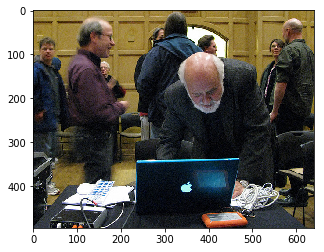

In [155]:
impath = '/home/ec2-user/SageMaker/SageMaker-Inference-Advanced/n-labs/11-manual-model-load/dcn/demo/COCO_test2015_000000000891.jpg'

img = imread(impath)
imshow(img)

In [160]:
resp_list = []
for e in eval(response)['array']:
    resp_list.append(np.array(e))

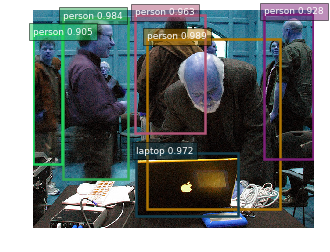

array([[[ 84, 138, 161],
        [ 77, 133, 158],
        [ 86, 143, 168],
        ...,
        [ 71, 130, 162],
        [ 64, 122, 157],
        [ 58, 130, 164]],

       [[ 81, 133, 156],
        [ 78, 132, 155],
        [ 81, 138, 160],
        ...,
        [ 63, 127, 157],
        [ 60, 127, 158],
        [ 44, 126, 157]],

       [[ 85, 137, 160],
        [ 86, 138, 161],
        [ 84, 138, 161],
        ...,
        [ 54, 125, 152],
        [ 53, 133, 158],
        [ 40, 132, 157]],

       ...,

       [[ 36,  30,  25],
        [ 44,  34,  27],
        [ 74,  60,  54],
        ...,
        [ 37,  68,  83],
        [ 17,  61,  74],
        [ 34,  68,  84]],

       [[ 43,  32,  28],
        [ 67,  52,  49],
        [ 78,  59,  54],
        ...,
        [ 48,  78,  89],
        [ 29,  71,  83],
        [ 44,  76,  89]],

       [[ 72,  57,  55],
        [ 69,  50,  47],
        [ 78,  56,  51],
        ...,
        [ 53,  82,  89],
        [ 30,  72,  79],
        [ 44,  74,  85]]

In [161]:
#im = cv2.imread('./dcn/demo/' + im_name)
im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
show_boxes(im, resp_list, classes, 1)

In [114]:
%time response = predictor.predict(image_packet.SerializeToString())            


CPU times: user 3.82 ms, sys: 355 µs, total: 4.17 ms
Wall time: 58.7 ms
